In [35]:
import numpy as np
import pandas as pd
import scipy as sp
import pathlib

import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx

import navis 
import navis.interfaces.neuprint as neu
import neuprint as neu_orig
import NeuromodPlasticity as nmp 


plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
c = nmp.connectomics.npt_client()

In [37]:
# load eb coords
ebcoords = nmp.connectomics.EBCoordinateSystem()
eb = neu.fetch_roi("EB")
eb.vertices = ebcoords.eb_vertices
eb.vertices[:,1] = -eb.vertices[:,1]  # flip y axis to match EB coordinates
eb.vertices[:,2] = -eb.vertices[:,2]

/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/connectomics.py:150: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=92). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  self._xsec_rad_spline = sp.interpolate.LSQBivariateSpline(eb_phase, xsec_phase, xsec_rad, knots, knots)


In [38]:
def add_eb_coords(syn_df, ebcoords, type='post'):
    syn_df.loc[:,['x_eb', 'y_eb', 'z_eb']] = ebcoords.change_of_basis(syn_df.loc[:,[f'x_{type}', f'y_{type}', f'z_{type}']].values)
    syn_df.loc[:, ['y_eb', 'z_eb']] = -1*syn_df.loc[:,['y_eb','z_eb']]
    phase, radius = ebcoords.get_circ_coordinates(syn_df.loc[:,['x_eb', 'y_eb', 'z_eb']].values)
    syn_df['phase'], syn_df['radius'] = phase, radius
    syn_df['radius_scaled'] = ebcoords.scale_radius(syn_df['phase'],syn_df['radius'])
    syn_df['xsec_phase'], syn_df['xsec_radius'] = ebcoords.get_xsec_coords(syn_df['phase'],syn_df['radius'], syn_df['z_eb'])
    syn_df['xsec_radius_scaled'] = ebcoords.scale_xsec_rad(syn_df['phase'], 
                                                            syn_df['xsec_phase'], 
                                                            syn_df['xsec_radius'])

    syn_df['xsec_x'] = syn_df['xsec_radius']*np.cos(syn_df['xsec_phase'])
    syn_df['xsec_y'] = syn_df['xsec_radius']*np.sin(syn_df['xsec_phase'])
    syn_df['xsec_x_scaled'] = syn_df['xsec_radius_scaled']*np.cos(syn_df['xsec_phase'])
    syn_df['xsec_y_scaled'] = syn_df['xsec_radius_scaled']*np.sin(syn_df['xsec_phase'])

def change_of_basis(navis_skeleton):
    nodes = navis_skeleton.nodes.copy()
    nodes.loc[:,('x','y','z')] = ebcoords.change_of_basis(nodes.loc[:,('x','y','z')].values)
    nodes.loc[:,'y'] = -nodes.loc[:,'y']  # flip y axis to match EB coordinates
    nodes.loc[:,'z'] = -nodes.loc[:,'z']
    nodes.head()
    navis_skeleton.set_neuron_attributes(nodes,name='nodes')
    return navis_skeleton

In [39]:
# load example ER4d, EPG and an EL that connects them
er4ds, _ = neu.queries.fetch_neurons(neu.NeuronCriteria(type = 'ER4d'))


els, _= neu.queries.fetch_neurons(neu.NeuronCriteria(type = 'EL'))
exr2s, _ = neu.queries.fetch_neurons(neu.NeuronCriteria(type='ExR2'))
exr3s, _ = neu.queries.fetch_neurons(neu.NeuronCriteria(type='ExR3'))
epgs, _= neu.queries.fetch_neurons(neu.NeuronCriteria(type = 'EPG'))

pens, _ = neu.queries.fetch_neurons(neu.NeuronCriteria(type='PEN_a.*'))

example_er4d_bodyId = er4ds['bodyId'].iloc[3]
neuron_df, conn_df = neu.queries.fetch_adjacencies(els['bodyId'], example_er4d_bodyId, rois='EB')
conn_df.sort_values('weight', ascending=False, inplace=True)
example_el_bodyId = conn_df['bodyId_pre'].iloc[0].copy()

neuron_df, conn_df = neu.queries.fetch_adjacencies(epgs['bodyId'], example_el_bodyId, rois='EB')
conn_df.sort_values('weight', ascending=False, inplace=True)
example_epg_bodyID = conn_df['bodyId_pre'].iloc[0].copy()



In [40]:
er4d_skel = neu.fetch_skeletons(example_er4d_bodyId)
er4d_skel = change_of_basis(er4d_skel)

el_skel = neu.fetch_skeletons(example_el_bodyId)
el_skel = change_of_basis(el_skel)

epg_skel = neu.fetch_skeletons(example_epg_bodyID)
epg_skel = change_of_basis(epg_skel)

pen_skel = neu.fetch_skeletons(pens['bodyId'].iloc[1])
pen_skel = change_of_basis(pen_skel)

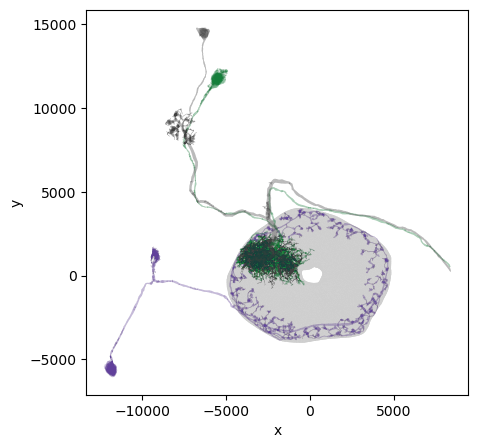

In [41]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = navis.plot2d(
                [eb, er4d_skel, el_skel, epg_skel],
                method="2d",
                connectors=False,
                linewidth=1.2,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "y"),
                color=(plt.cm.Purples(.8), 
                       plt.cm.Greens(.8),
                       plt.cm.Greys(.8),
                       plt.cm.Greys(.3)),
                alpha=.2,
                radius=True,
                ax=ax,
            )
ax.grid(False)

In [42]:

er4d_epg_synapses = neu_orig.fetch_synapse_connections(example_er4d_bodyId,
                                                       epgs['bodyId'], #example_epg_bodyID,
                                                       neu_orig.SynapseCriteria(rois='EB'))

add_eb_coords(er4d_epg_synapses, ebcoords, type='pre')

el_er4d_synapses = neu_orig.fetch_synapse_connections(els['bodyId'], #example_el_bodyId,
                                                      example_er4d_bodyId,
                                                      neu_orig.SynapseCriteria(rois='EB'))

add_eb_coords(el_er4d_synapses, ebcoords, type='post')

# er4d_neu_skel = neu_orig.fetch_skeleton(example_er4d_bodyId)
# er4d_neu_skel = neu_orig.skeleton.upsample_skeleton(er4d_neu_skel)




  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

(-5000.0, 5000.0)

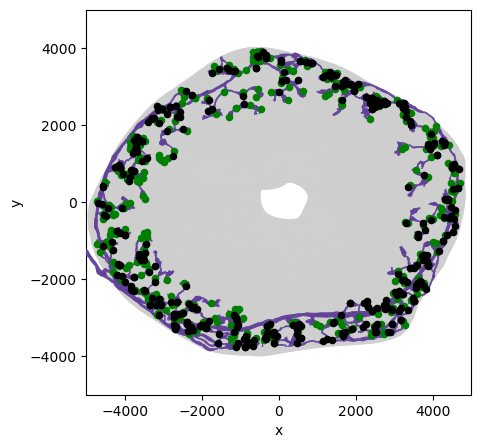

In [43]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = navis.plot2d(
                [eb, er4d_skel],
                method="2d",
                connectors=False,
                linewidth=1.2,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "y"),
                color=(plt.cm.Purples(.8), 
                       plt.cm.Greys(.3)),
                alpha=1,
                radius=True,
                ax=ax,
            )
ax.grid(False)

ax.scatter(er4d_epg_synapses.loc[:,'x_eb'], 
           er4d_epg_synapses.loc[:,'y_eb'],
           s=20, color='black',zorder=101) #plt.cm.Greys(.8))

ax.scatter(el_er4d_synapses.loc[:,'x_eb'],
           el_er4d_synapses.loc[:,'y_eb'],
           s=20, color='green',zorder=100) #color=plt.cm.Greens(.8))

ax.set_xlim([-5000, 5000])
ax.set_ylim([-5000,5000])

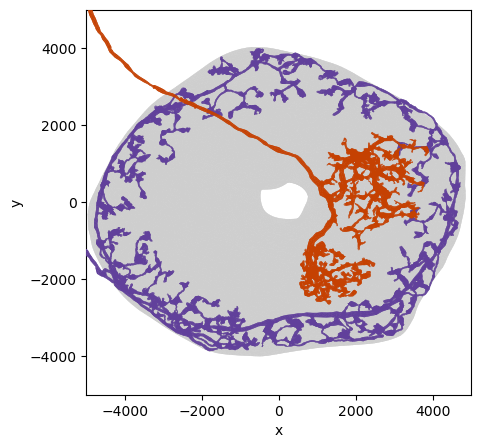

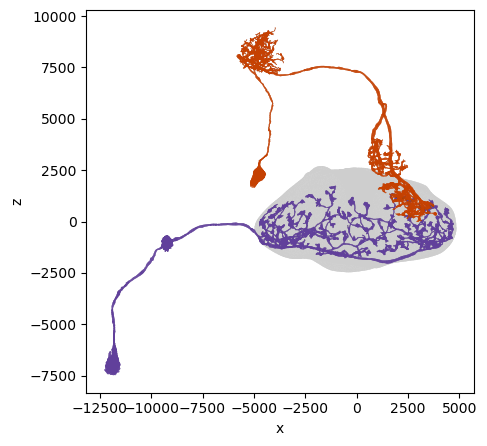

In [44]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = navis.plot2d(
                [eb, er4d_skel, pen_skel],
                method="2d",
                connectors=False,
                linewidth=1.2,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "y"),
                color=(plt.cm.Purples(.8),
                       plt.cm.Oranges(.8), 
                       plt.cm.Greys(.3)),
                alpha=1,
                radius=True,
                ax=ax,
            )
ax.grid(False)



ax.set_xlim([-5000, 5000])
ax.set_ylim([-5000,5000])

fig, ax = plt.subplots(figsize=(5, 5))
_ = navis.plot2d(
                [eb, er4d_skel, pen_skel],
                method="2d",
                connectors=False,
                linewidth=1.2,  # Make neuron a bit thinner to emphasize the synapses
                view=("x", "z"),
                color=(plt.cm.Purples(.8),
                       plt.cm.Oranges(.8), 
                       plt.cm.Greys(.3)),
                alpha=1,
                radius=True,
                ax=ax,
            )
ax.grid(False)


In [45]:
pen_er4d_synapses = neu_orig.fetch_synapse_connections(pens['bodyId'],
                                                       er4ds['bodyId'],
                                                       neu_orig.SynapseCriteria(rois='EB'))
pen_er4d_synapses

  0%|          | 0/72 [00:00<?, ?it/s]

,bodyId_pre,bodyId_post,roi_pre,roi_post,x_pre,y_pre,z_pre,x_post,y_post,z_post,confidence_pre,confidence_post
0,508793049,1167891559,EB,EB,26682,23598,17725,26691,23592,17707,0.983,0.944476
1,508793049,1167891559,EB,EB,26630,23583,17705,26650,23590,17681,0.973,0.474235
2,570461892,1198931241,EB,EB,28375,25397,23506,28379,25404,23520,0.982,0.877545
3,570461892,1416900410,EB,EB,28375,25397,23506,28363,25409,23520,0.982,0.874056
4,570461892,1416900410,EB,EB,28323,25288,23462,28310,25282,23469,0.992,0.988664
...,...,...,...,...,...,...,...,...,...,...,...,...
67,5813080979,1416900410,EB,EB,23308,24285,18039,23321,24271,18027,0.885,0.998468
68,5813080979,1416900410,EB,EB,23311,24299,17996,23325,24284,17996,0.960,0.988863
69,5813080979,1198931241,EB,EB,22603,24633,19221,22561,24640,19205,0.875,0.476058
70,5813080979,1167300154,EB,EB,22842,24458,18913,22842,24489,18893,0.964,0.456183


In [46]:
# get synapses from example ER4d to EPG and EL to example ER4d
er4d_epg_synapses = neu_orig.fetch_synapse_connections(example_er4d_bodyId,
                                                       epgs['bodyId'], #example_epg_bodyID,
                                                       neu_orig.SynapseCriteria(rois='EB'))

el_er4d_synapses = neu_orig.fetch_synapse_connections(els['bodyId'], #example_el_bodyId,
                                                      example_er4d_bodyId,
                                                      neu_orig.SynapseCriteria(rois='EB'))
#exr2
exr2_er4d_synapses = neu_orig.fetch_synapse_connections(exr2s['bodyId'],
                                                       example_er4d_bodyId,
                                                       neu_orig.SynapseCriteria(rois='EB'))

#exr3
exr3_er4d_synapses = neu_orig.fetch_synapse_connections(exr3s['bodyId'],
                                                        example_er4d_bodyId,
                                                        neu_orig.SynapseCriteria(rois='EB'))

#pen

er4d_epg_synapses['type'] = 'epg_pre'
er4d_epg_synapses['x'], er4d_epg_synapses['y'], er4d_epg_synapses['z'] = er4d_epg_synapses['x_pre'], er4d_epg_synapses['y_pre'], er4d_epg_synapses['z_pre']


el_er4d_synapses['type'] = 'el_post'
el_er4d_synapses['x'], el_er4d_synapses['y'], el_er4d_synapses['z'] = el_er4d_synapses['x_post'], el_er4d_synapses['y_post'], el_er4d_synapses['z_post']

exr2_er4d_synapses['type'] = 'exr2_post'
exr2_er4d_synapses['x'], exr2_er4d_synapses['y'], exr2_er4d_synapses['z'] = exr2_er4d_synapses['x_post'], exr2_er4d_synapses['y_post'], exr2_er4d_synapses['z_post']

exr3_er4d_synapses['type'] = 'exr3_post'
exr3_er4d_synapses['x'], exr3_er4d_synapses['y'], exr3_er4d_synapses['z'] = exr3_er4d_synapses['x_post'], exr3_er4d_synapses['y_post'], exr3_er4d_synapses['z_post']



syns = pd.concat(( er4d_epg_synapses, el_er4d_synapses, exr2_er4d_synapses, exr3_er4d_synapses), ignore_index=True)

# attach synapses to skeleton

er4d_skel = neu_orig.fetch_skeleton(example_er4d_bodyId, heal=True,with_distances=True)
er4d_skel = neu_orig.upsample_skeleton(er4d_skel, 1)
er4d_skel = neu_orig.attach_synapses_to_skeleton(er4d_skel, syns)
# er4d_skel = neu_orig.attach_synapses_to_skeleton(er4d_skel, el_er4d_synapses)


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [47]:
er4d_skel['structure'].unique()

['neurite', 'epg_pre', 'el_post', 'exr2_post', 'exr3_post']
Categories (5, object): ['el_post', 'epg_pre', 'exr2_post', 'exr3_post', 'neurite']

In [48]:
# make dictionary with rowID and structure
struct_dict = {}
for _, row in er4d_skel.iterrows():
    struct_dict[row['rowId']]=row['structure']

In [49]:
er4d_nx = neu_orig.skeleton_df_to_nx(er4d_skel, with_distances=True,directed=False)
nx.set_node_attributes(er4d_nx, struct_dict, 'structure')

In [51]:
pre_syns = er4d_skel.loc[er4d_skel['structure']=='epg_pre']
pre_nodes= [row['rowId'] for _, row in pre_syns.iterrows()]

In [55]:
# pre_syns = er4d_skel.loc[er4d_skel['structure']=='pre']
# from skeleton_df find presynapses
post_syns = er4d_skel.loc[er4d_skel['structure']=='exr2_post']
post_nodes = []
for _, row in post_syns.iterrows():
    # rowid = row['rowId']
    post_nodes.append(row['rowId'])

# for each presynapse


In [56]:
from multiprocessing import Pool

def calc_dist(pre_node):
    dist, path = nx.multi_source_dijkstra(er4d_nx, post_nodes, target=pre_node, weight='distance')
    return dist

with Pool(processes=8) as pool:
    distances = pool.map(calc_dist, pre_nodes)



(array([89., 64., 36., 53., 29., 33., 13., 22., 19.,  6.]),
 array([ 0.53895033,  6.19250772, 11.8460651 , 17.49962249, 23.15317987,
        28.80673726, 34.46029464, 40.11385203, 45.76740941, 51.4209668 ,
        57.07452418]),
 <BarContainer object of 10 artists>)

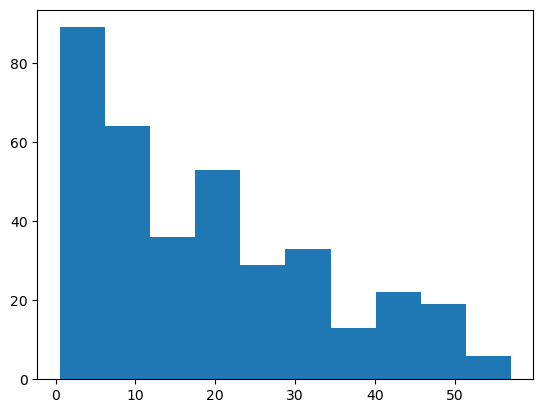

In [59]:
fig, ax = plt.subplots()
ax.hist(np.array(distances)*8/1000)

In [ ]:
from multiprocessing import Pool

def calc_dist(pre_node):
    dist, path = nx.multi_source_dijkstra(er4d_nx, post_nodes, target=pre_node, weight='distance')
    return dist

with Pool(processes=8) as pool:
    distances = pool.map(calc_dist, pre_nodes)



In [26]:
import os
os.cpu_count()

24